# Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)



This notebook accompanies the blog "Improving Amazon Transcribe transcriptions using Custom Vocabularies and Amazon Augmented AI (A2I)" (TODO: add link)

## Introduction
When transcribing speech containing domain-specific terminologies in fields such as legal, financial, construction, higher education, or engineering, Amazon Transcribe’s [custom vocabularies](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html) feature can be an advantageous tool to improve transcription quality. This works great for cases in which a list of domain-specific terms is already available. However, for cases in which a list of terms has yet to be generated, identifying technical terms and phrases associated with these terms may require intermediate interpretation work from human teams.

Amazon Augmented AI (A2I) can provide an organized workflow to manage the use of human interpretation in building a custom vocabulary list, which can then be used in future transcriptions and also become a valuable intellectual property asset.

## What's in this notebook?

1. **Initial transcription —** The example we’ll be transcribing in this post is an introductory [video](https://www.youtube.com/watch?v=uQc8Itd4UTs) about Amazon SageMaker, which contains many mentions of technical machine learning and AWS terms. When using Amazon Transcribe “out-of-the-box,” you’ll find that many of these technical mentions are mis-transcribed. We’ll take a look at a distribution of confidence scores to see some of the terms that Amazon Transcribe has difficulty transcribing.
2. **Human review workflow with A2I —** Once we’ve identified words with low confidence scores, we can send them in for human review. You’ll set up the A2I workflow and associated resources for doing this. Once a human loop request is received, Amazon A2I will handle the job of assigning tasks to your configured workforce. Amazon A2I uses [Amazon Cognito](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-create-private-cognito.html) to provide user authentication.
3. **Building custom vocabularies —**  When your workforce finishes transcribing all tasks, we can parse through them to extract domain-specific terms and use them to create a custom vocabulary table. 
4. **Improved transcription —** Once we have a custom vocabulary with our domain-specific terms, we can call Amazon Transcribe again to get improved transcription results. You’ll evaluate and compare the before and after performances using an industry standard called word error rate (WER).

For more sample notebooks using A2I, visit this [Github repository](https://github.com/aws-samples/amazon-a2i-sample-jupyter-notebooks).

### Install Latest SDKs

In [ ]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip
!pip install boto3 --upgrade
!pip install -U botocore

### Setup

In [16]:
from __future__ import print_function
import time
import boto3
import json

### Region, Bucket, and Paths
blah blah blah

In [8]:


REGION = 'us-west-2'
BUCKET = "jashuang-sagemaker-5-22"
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

### Roles and Permissions
blah blah blah

Need to grant access for the following:
  * AmazonSageMakerFullAccess
  * AmazonS3FullAccess 
  * AmazonAugmentedAIFullAccess

In [90]:
from sagemaker import get_execution_role

ROLE = get_execution_role()
display(ROLE)

'arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20200522T134110'

## Basic Transcription Job
Here, we use Amazon Transcribe with default settings

In [14]:
s3 = boto3.client("s3", REGION)

job_name_1 = "AWS-sage-1"
# audio file path
job_uri_s3 = "s3://jashuang-sagemaker-5-22/transcribe-bucket/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4"


In [ ]:
# Here is a transcribe function
def transcribe(job_name, job_uri, out_bucket, format="mp4", vocab_name=None):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
        vocab_name (str): name of custom vocabulary used;
                          optional, defaults to None
    """
    
    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        transcribe = boto3.client("transcribe")
        print("------" + format)
        transcribe.start_transcription_job(
            TranscriptionJobName=job_name,
            Media={"MediaFileUri": job_uri},
            MediaFormat=format,
            LanguageCode="en-US",
            OutputBucketName=out_bucket,
            Settings={'VocabularyName': vocab_name}
        )
        
        while True:
            status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(5)
        print(status)

    except Exception as e:
        print(e)

In [ ]:
# transcribe(job_name_1, job_uri_s3, BUCKET)

### Get Transcripts, Confidence Scores, and Timestamps


In [12]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from s3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (
        entire_transcript: str,
        sentences_and_times: [ {start_time (sec) : float,
                                end_time (sec)   : float,
                                sentence         : str,
                                min_confidence   : float (minimum confidence score of that sentence)
                                } ],
        confidences:  [ {start_time (sec) : float,
                         end_time (sec)   : float,
                         content          : str, (single word/phrase)
                         confidence       : float (confidence score of the word/phrase)
                         } ],
        scores: list of confidence scores
        )
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1

    return entire_transcript, sentences_and_times, confidences, scores

In [17]:
entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps("jashuang-sagemaker-5-22","AWS-sage-1.json")

In [45]:
print(sentences_and_times_1[0])

{'start_time': 0.54, 'end_time': '1.03', 'sentence': 'Hi.', 'min_confidence': 1.0}


### Save the first transcript to a txt file

In [ ]:
file0 = open("originaltranscript.txt","w") 
for tup in sentences_and_times_1:
    file0.write(tup['sentence'] + "\n") 
file0.close()

### Histogram of confidence scores

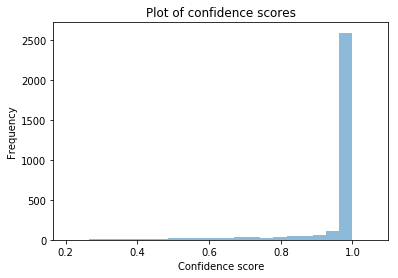

In [18]:
from matplotlib import pyplot as plt

plt.xlim([min(scores_1)-0.1, max(scores_1)+0.1])
plt.hist(scores_1, bins=20, alpha=0.5)
plt.title('Plot of confidence scores')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

### Histogram of low confidence scores

In [21]:
bad_scores = [i for i in scores_1 if i < 0.9]

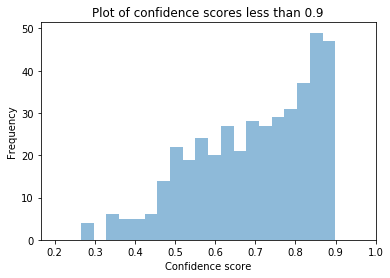

In [22]:
plt.xlim([min(bad_scores)-0.1, 1.0])
plt.hist(bad_scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores less than 0.9')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

### Workteam or Workforce
blah blah blah

In [29]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-west-2:688520471316:workteam/private-crowd/jashuang-test-workforce"

### Clients

In [26]:
import io
import json
import uuid
import time
import boto3
import botocore

# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', REGION)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

s3 = boto3.client('s3', REGION)

## Create Control Plane Resources

### Create Human Task UI

In [84]:
template = r"""
<head>
    <style>
        h1 {
            color: black;
            font-family: verdana;
            font-size: 150%;
        }
    </style>
</head>
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <video id="this_vid">
        <source src="{{ task.input.audioPath | grant_read_access }}"
            type="audio/mp4">
        Your browser does not support the audio element.
    </video>
    <br />
    <br />
    <crowd-button onclick="onClick(); return false;"><h1> Click to play video section!</h1></crowd-button> 

    <h3>Instructions</h3>
    <p>Transcribe the audio clip </p>
    <p>Ignore "umms", "hmms", "uhs" and other non-textual phrases. </p>
    <p>The original transcript is <strong>"{{ task.input.original_words }}"</strong>. If the text matches the audio, please retype the same transcription.</p>
    <p>Click the space below to start typing.</p>
    <crowd-text-area name="transcription" rows="2" label="Your transcription" placeholder="Please enter the transcribed text."></crowd-text-area>

    <full-instructions header="Transcription Instructions">
        <h2>Instructions</h2>
        <p>Click the play button and listen carefully to the audio clip. Type what you hear in the box
            below. Replay the clip by clicking the button again, as many times as needed.</p>
    </full-instructions>

</crowd-form>

<script>
    var video = document.getElementById('this_vid');
    video.onloadedmetadata = function() {
        video.currentTime = {{ task.input.start_time }};
    };
    function onClick() {
        video.pause();
        video.currentTime = {{ task.input.start_time }};
        video.play();
        video.ontimeupdate = function () {
            if (video.currentTime >= {{ task.input.end_time }}) {
                video.pause()
            }
        }
    }
</script>
"""

#t={{ task.input.start_time }},{{ task.input.end_time }}

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [85]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-west-2:688520471316:human-task-ui/ui-transcribe-d87bdcde-2919-4e2f-8ee3-e95d10eb61e8


In [86]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-transcribe-demo-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word(s) spoken in the provided audio clip",
            "TaskTitle": "Determine Words/Phrases of Audio Clip"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [87]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Initializing
Active
Flow Definition is active


## Human Loops
### Sending sequences of words/phrases of low confidence for review
As we iterate through the list of words and their confidence scores, we create a HumanLoop task whenever the confidence score is below a threshold. The task consists of a sequence of words "neighboring" the word with low confidence, since it is possible that nearby words/phrases were also mis-transcribed.

In [88]:
# use this to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index):
    """
    gets the words transcribe found at most 3 away from the input index
    Returns:
        list: words at most 3 away from the input index
        int: starting time of the first word in the list
        int: ending time of the last word in the list
    """
    i = max(0, index - 3)
    j = min(len(words) - 1, index + 3)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

In [89]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = .4
i = 0
for obj in confidences_1:
    word = obj["content"]
    neighbors, start_time, end_time = get_word_neighbors(confidences_1, i)
    
    # Our condition for when we want to engage a human for review
    if (obj["confidence"] < CONFIDENCE_SCORE_THRESHOLD):
        
        # get the original sequence of words
        sequence = ""
        for block in neighbors:
            sequence += block['content'] + " "
        
        humanLoopName = str(uuid.uuid4())
        # "initialValue": word,
        inputContent = {
            "audioPath": job_uri_s3,
            "start_time": start_time,
            "end_time": end_time,
            "original_words": sequence
        }
        start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(inputContent)
            }
        )
        human_loops_started.append(humanLoopName)
        print(f'Confidence score of {obj["confidence"]} is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}')
        print(f'Starting human loop with name: {humanLoopName}')
        print(f'Sending words from times {start_time} to {end_time} to review')
        print(f'The original transcription is ""{sequence}"" \n')
#     else:
# #         print(f'SentimentScore of {obj["confidence"]} is above threshold of {CONFIDENCE_SCORE_THRESHOLD}')
# #         print('No human loop created. \n')

    i=i+1

Confidence score of 0.3945 is less than the threshold of 0.4
Starting human loop with name: d48932f6-77f3-4128-8346-bee9d86f953e
Sending words from times 44.2 to 46.37 to review
The original transcription is ""show up Under are easy to console "" 

Confidence score of 0.3907 is less than the threshold of 0.4
Starting human loop with name: 0a103dfc-cd6f-46c7-bc0f-9b9c6adee01f
Sending words from times 69.11 to 72.08 to review
The original transcription is ""And more cores see is compute optimized "" 

Confidence score of 0.3542 is less than the threshold of 0.4
Starting human loop with name: acec9c14-8b0e-4b8b-a8ae-f5d58b7cd52a
Sending words from times 89.94 to 92.93 to review
The original transcription is ""every version of Annecy two instance is "" 

Confidence score of 0.3372 is less than the threshold of 0.4
Starting human loop with name: c69c9cde-d258-44aa-a1fb-46a33391d0af
Sending words from times 338.43 to 340.78 to review
The original transcription is ""distributing data sets wan

In [70]:
file_hl = open("human_loops_names.txt","w") 
for name in human_loops_started:
    file_hl.write(name + "\n") 
file_hl.close()

### Check Status of Human Loop

In [ ]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

### Wait For Workers to Complete Task
We display the link to the private worker portal here for convenience.

In [35]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://v3t960yxw8.labeling.us-west-2.sagemaker.aws


### Check Status of Human Loop Again

In [46]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)


HumanLoop Name: 0ca4a2c1-858b-4dcf-882b-1c84dad5217f
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c/2020/06/04/17/39/49/0ca4a2c1-858b-4dcf-882b-1c84dad5217f/output.json'}


HumanLoop Name: e6d41808-0b59-46de-8467-a474ae67fd98
HumanLoop Status: InProgress
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c/2020/06/04/17/39/49/e6d41808-0b59-46de-8467-a474ae67fd98/output.json'}


HumanLoop Name: c020e21e-cc2a-4d36-8fb6-e6fd7193dc87
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c/2020/06/04/17/39/49/c020e21e-cc2a-4d36-8fb6-e6fd7193dc87/output.json'}


HumanLoop Name: 8eba603b-8257-4fd9-9c35-d6af84b5bc7b
HumanLoop Status: Completed
HumanLoop Output Destin

### View Task Results

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed.

In [47]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

{   'flowDefinitionArn': 'arn:aws:sagemaker:us-west-2:688520471316:flow-definition/fd-transcribe-demo-21d6e7b4-9540-4180-ae1b-b7010384f24c',
    'humanAnswers': [   {   'answerContent': {   'transcription': 'every '
                                                                  'version of '
                                                                  'an ec2 '
                                                                  'instance '
                                                                  'is'},
                            'submissionTime': '2020-06-04T22:05:56.066Z',
                            'workerId': '65bf0cafa9867643',
                            'workerMetadata': {   'identityData': {   'identityProviderType': 'Cognito',
                                                                      'issuer': 'https://cognito-idp.us-west-2.amazonaws.com/us-west-2_rDB2Sn2uV',
                                                                      'sub': 'a56c8c5c-db1e

### Get Technical Terms
To get the technical terms identified by human review, we first accumulate all human-reviewed words into a list.

In [48]:
corrected_words = []

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    
    # add the human-reviewed answers split by spaces
    corrected_words += json_output['humanAnswers'][0]['answerContent']['transcription'].split(" ")

In [49]:
print(corrected_words)

['every', 'version', 'of', 'an', 'ec2', 'instance', 'is', 'distributing', 'data', 'sets', 'what', 'about', 'pipe', 'mode', 'but', 'definitely', 'use', 'Lambda', 'to', 'turn', 'your']


In [43]:
# Create dictionary of English words
# Note that this corpus of words is not 100% exhaustive
import nltk
nltk.download('words')
from nltk.corpus import words
my_dict=set(words.words()) 

[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [41]:
# Function for extracting words not in the English language corpus
def unusual_words(text):
    text_vocab = set(w.lower() for w in text)
    english_vocab = set(w.lower() for w in my_dict)
    unusual = text_vocab - english_vocab
    return sorted(unusual)

# Function for removing contractions
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
def remove_contractions(word_list):
    return [word for word in word_list if word not in contractions]

### View Technical/Uncommon Words
After removing contractions, human-reviewed words that are not in the English language corpus are likely to be the technical terms we are looking for.

In [50]:
for word in remove_contractions(corrected_words):
    if word not in my_dict:
        print(word)

ec2
distributing
sets
Lambda


### Create Custom Vocabulary
Using the technical terms identified above, we created a custom vocabulary of those terms that we want Transcribe to be able to recognize. A custom vocabulary table enables options to tell Amazon Transcribe how each technical term is pronounced and how it should be displayed.

More details on how to form a custom vocabulary table can be found here: https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html#create-vocabulary-table

In [ ]:
finalized_words=[['Phrase','IPA','SoundsLike','DisplayAs'],
                 ['E.C.-Two','','ee-see-too','EC2'],
                 ['E.C.-Two-instance','','ee-see-too-in-stunce','EC2 instance'],
                 ['lambda','','lam-duh','Lambda'],
                 ['S.D.K.','','ess-dee-kay','SDK'],
                 ['boto-three','','boe-toe-three','Boto3'],
                 ['S.-Three','','ess-three','S3'],
                 ['github','','git-hub','Github'],
                 ['sagemaker','','sage-may-ker','SageMaker'],
                 ['E.B.S.','','ee-bee-ess','EBS'],
                 ['G.P.U.','','gee-pee-you','GPU'],
                 ['git-repository','','git-ree-paw-zih-tor-ee','Git repository'],
                 ['jupyter','','joo-pih-ter','Jupyter'],
                 ['kernel','','ker-null','kernel'],
                 ['config','','con-fig','config'],
                 ['configs','','con-figs','configs'],
                 ['D.B.-pedia','','dee-bee-pee-dee-yuh','dbpedia'],
                 ['git-clone','','','git clone'],
                 ['notebook-instance','','','notebook instance'],
                 ['V.P.C.','','','VPC'],
                ]

### Write the Table to a Txt File

In [ ]:
custom_vocab_file_name = "customvocab3.txt"
file1 = open(custom_vocab_file,"w")
template = '{}\t{}\t{}\t{}\n'
for line in finalized_words:
    file1.write(template.format(line[0],
                                line[1],
                                line[2],
                                line[3])
               )
file1.close()

### Upload Custom Vocabulary File to S3

In [ ]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
upload_file(custom_vocab_file_name, BUCKET)

### Create the Custom Vocabulary

In [ ]:
vocab_improved='aws-sagemaker-vocab-4'

In [ ]:
transcribe = boto3.client("transcribe")
response = transcribe.create_vocabulary(
    VocabularyName=vocab_improved,
    LanguageCode='en-US',
    VocabularyFileUri='s3://' + BUCKET + '/' + custom_vocab_file_name
)

In [ ]:
pp.pprint(response)

In [ ]:
# Get the status of the vocab you created again (must wait until its VocabularyState is READY)
response2 = transcribe.get_vocabulary(
    VocabularyName=vocab_improved
)
pp.pprint(response2)

### Re-transcribe using the Custom Vocabulary

In [ ]:
job_name_2='AWS-sage-improved-1'

In [ ]:
transcribe(job_name_2, job_uri_s3, BUCKET, vocab_name=vocab_improved)

In [ ]:
entire_transcript_2,sentences_and_times_2, confidences_2, scores_2 = get_transcript_text_and_timestamps(BUCKET,
                                                                                                      job_name_2+".json")
                                                                                                       

### Write the Improved Transcript to Txt File

In [ ]:
# save the improved transcript
file4 = open("improvedtranscript_2.txt","w") 
for tup in sentences_and_times_2:
    file4.write(tup['sentence'] + "\n") 
file4.close()

## Calculating Word Error Rate (WER)
We'll be using a lightweight open-source Python library called JiWER for calculating WER between transcripts.

For more details, see: https://pypi.org/project/jiwer/

In [ ]:
!pip install jiwer

In [ ]:
from jiwer import wer
import jiwer

In [ ]:
# small example
ground_truth = "hello world"
hypothesis = "hello duck"

In [ ]:
wer(ground_truth, hypothesis)

In [ ]:
# Create a transformation function to preprocess transcript
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.SentencesToListOfWords(),
    jiwer.SentencesToListOfWords(word_delimiter=" "),
    jiwer.RemoveEmptyStrings()
]) 

### Get the original transcript (before applying the custom vocabulary)

In [ ]:
hypothesis_2_original = ""
f3 = open("originaltranscript.txt", "r")
for line in f3:
    if line.strip() == "--STOP--":
        break
    hypothesis_2_original += (line.strip() + " ")
f3.close()

### Get the "Ground Truth" transcript

In [ ]:
ground_truth_2 = ""
f1 = open("ground_truth.txt", "r")
for line in f1:
    if line.strip() == "--STOP--":
        break
    ground_truth_2 += (line.strip() + " ")
f1.close()

### Get the new transcript (after applying the custom vocabulary)

In [ ]:
hypothesis_2 = ""
f2 = open("improvedtranscript_2.txt", "r")
for line in f2:
    if line.strip() == "--STOP--":
        break
    hypothesis_2 += (line.strip() + " ")
f2.close()

### Compute Baseline Accuracy

In [ ]:
jiwer.wer(
    ground_truth_2, 
    hypothesis_2_original, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

### Compute New Accuracy

In [ ]:
jiwer.wer(
    ground_truth_2, 
    hypothesis_2, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)